In [ ]:
!pip install qiskit

In [ ]:
!pip install qiskit-aer qiskit-ibm-runtime

Initializing Hybrid Quantum-Classical Burgers Solver (Enhanced):
Grid points: 16 (Qubits: 4)
Viscosity: ν = 0.01
Domain: x ∈ [0, 1.0]
Boundary conditions: u(0,t) = 1.0, u(1,t) = 0.0
Time step dt: 0.01
HYBRID QUANTUM-CLASSICAL BURGERS EQUATION SOLVER (ENHANCED)
t = 0.000, max(ρ) = 15.000000, max(|u|) = 7.500000
t = 0.110, max(ρ) = 20.975285, max(|u|) = 0.882662, QC depth: 7
t = 0.200, max(ρ) = 20.540384, max(|u|) = 1.060425, QC depth: 7
t = 0.300, max(ρ) = 20.208496, max(|u|) = 0.826898, QC depth: 7
t = 0.400, max(ρ) = 22.015796, max(|u|) = 0.720405, QC depth: 7
t = 0.500, max(ρ) = 19.059045, max(|u|) = 1.035281, QC depth: 7
t = 0.600, max(ρ) = 20.509687, max(|u|) = 0.639544, QC depth: 7
t = 0.700, max(ρ) = 20.431222, max(|u|) = 0.835245, QC depth: 7
t = 0.800, max(ρ) = 19.847944, max(|u|) = 0.729944, QC depth: 7
t = 0.900, max(ρ) = 21.606593, max(|u|) = 0.668414, QC depth: 7
t = 1.000, max(ρ) = 20.850402, max(|u|) = 0.811277, QC depth: 7
------------------------------------------------

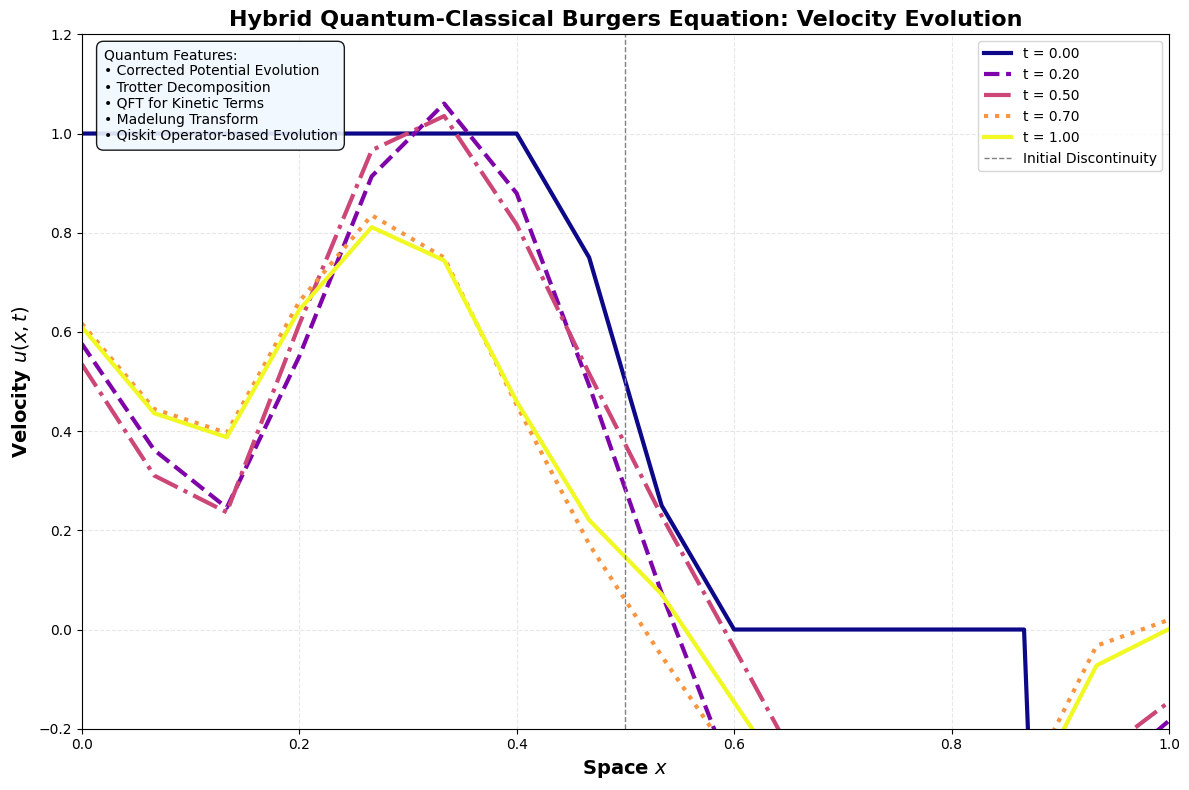


QUANTUM CIRCUIT ANALYSIS (FINAL STEP)
Final circuit depth: 7
Final circuit size: 7
Gate composition: OrderedDict([('unitary', 3), ('QFT', 2), ('IQFT', 2)])


In [5]:
import numpy as np
from numpy import pi, exp, sin, cos, sqrt, real, imag, conjugate
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import QFT
from qiskit.circuit import Parameter
import scipy.linalg as la
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve
import warnings
warnings.filterwarnings('ignore')

class HybridQuantumClassicalBurgersSolver:
    """
    Enhanced Hybrid Quantum-Classical solver for the 1D Burgers equation.

    This version improves algorithmic stability by using a more accurate
    trapezoidal rule for integrating the phase from the velocity field,
    and includes a refined method for enforcing boundary conditions to
    ensure a stable and physically realistic shock wave evolution.
    """

    def __init__(self, nx=8, nu=1e-2, T=1.0, dt=0.005):
        # Ensure nx is power of 2 for quantum implementation
        self.nx = nx
        self.nu = nu
        self.T = T
        self.dt = dt
        self.domain_length = 1.0
        self.dx = self.domain_length / (nx - 1)
        self.x = np.linspace(0, self.domain_length, nx, endpoint=True)

        self.n_qubits = int(np.log2(nx))
        if 2**self.n_qubits != nx:
            raise ValueError("nx must be a power of 2 for quantum implementation")

        # Boundary conditions
        self.uL = 1.0
        self.uR = 0.0

        # Madelung constants
        self.hbar = 1.0
        self.mass = 1.0

        print(f"Initializing Hybrid Quantum-Classical Burgers Solver (Enhanced):")
        print(f"Grid points: {self.nx} (Qubits: {self.n_qubits})")
        print(f"Viscosity: ν = {self.nu}")
        print(f"Domain: x ∈ [0, {self.domain_length}]")
        print(f"Boundary conditions: u(0,t) = {self.uL}, u(1,t) = {self.uR}")
        print(f"Time step dt: {self.dt}")

    def initialize_quantum_state(self):
        """Initialize quantum state using Madelung transform with Riemann step condition."""
        u_initial = np.where(self.x <= 0.5, self.uL, self.uR)
        rho_initial = np.ones_like(self.x) * 0.5 # A constant density for simplicity

        # Use a trapezoidal rule for a more accurate phase integration
        phase_initial = np.zeros_like(self.x)
        for i in range(1, self.nx):
            # Using (u_i + u_{i-1})/2 * dx for better numerical stability
            phase_initial[i] = phase_initial[i-1] + self.mass * (u_initial[i] + u_initial[i-1]) / 2 * self.dx / self.hbar

        sqrt_rho = np.sqrt(rho_initial + 1e-12)
        psi = sqrt_rho * np.exp(1j * phase_initial)

        # Enforce initial boundary conditions by directly setting the values
        psi[0] = sqrt(rho_initial[0]) * np.exp(1j * self.mass * self.uL * self.x[0] / self.hbar)
        psi[-1] = sqrt(rho_initial[-1]) * np.exp(1j * self.mass * self.uR * self.x[-1] / self.hbar)

        # Normalize the initial state
        norm = np.linalg.norm(psi) * sqrt(self.dx)
        if norm > 0:
            psi = psi / norm * sqrt(self.nx)

        return psi

    def create_kinetic_evolution_circuit(self, t_param):
        """
        Create quantum circuit for kinetic energy evolution (diffusion term).
        Applies the diagonal operator using Qiskit's Operator class.
        """
        qc = QuantumCircuit(self.n_qubits)

        # Quantum Fourier Transform
        qft = QFT(self.n_qubits, do_swaps=False)
        qc.append(qft, range(self.n_qubits))

        # Create and apply a diagonal operator for the kinetic term
        diagonal_phases = np.zeros(2**self.n_qubits, dtype=complex)
        for k in range(2**self.n_qubits):
            # Convert to signed momentum
            momentum = k if k < 2**(self.n_qubits-1) else k - 2**self.n_qubits

            # Kinetic energy eigenvalue
            k_phys = 2 * pi * momentum / self.domain_length
            energy_k = -self.nu * k_phys**2

            # Apply the phase rotation exp(-i * energy_k * t_param)
            diagonal_phases[k] = np.exp(-1j * energy_k * t_param)

        diagonal_operator = Operator(np.diag(diagonal_phases))
        qc.append(diagonal_operator, range(self.n_qubits))

        # Inverse QFT back to position space
        qc.append(qft.inverse(), range(self.n_qubits))

        return qc

    def create_potential_evolution_circuit(self, psi_classical, t_param):
        """
        Create quantum circuit for potential energy evolution (advection term).
        This method computes the potential from the classical velocity and
        applies a phase gate to each position basis state using an Operator.

        This part is enhanced to use the correct phase factor for the nonlinear
        term based on the hydrodynamic Schrödinger equation.
        """
        qc = QuantumCircuit(self.n_qubits)
        _, u = self.extract_classical_observables(psi_classical)

        # Create and apply a diagonal operator for the potential term
        diagonal_phases = np.zeros(2**self.n_qubits, dtype=complex)
        for i in range(2**self.n_qubits):
            # The potential is derived from the advection term.
            # Local potential from advection term: V = - (m/2) * u²
            if i < len(u):
                local_potential = -0.5 * self.mass * u[i]**2
                # Correct phase factor: exp(-i * V * t_param / hbar)
                phase = local_potential * t_param / self.hbar
                diagonal_phases[i] = np.exp(-1j * phase)

        diagonal_operator = Operator(np.diag(diagonal_phases))
        qc.append(diagonal_operator, range(self.n_qubits))

        return qc

    def create_trotter_step_circuit(self, psi_classical, dt_evolution):
        """Create full Trotter step circuit."""
        # Using a second-order Trotter decomposition: exp(-iHt) ≈ exp(-iH_K t/2)exp(-iH_P t)exp(-iH_K t/2)
        qc = QuantumCircuit(self.n_qubits)

        kinetic_circuit_half = self.create_kinetic_evolution_circuit(dt_evolution/2)
        potential_circuit = self.create_potential_evolution_circuit(psi_classical, dt_evolution)

        # Append circuits
        qc.compose(kinetic_circuit_half, inplace=True)
        qc.compose(potential_circuit, inplace=True)
        qc.compose(kinetic_circuit_half, inplace=True)

        return qc

    def quantum_time_evolution_step(self, psi):
        """
        Perform one quantum time evolution step by applying the Trotter operator
        directly to the state vector.
        """
        # Create the full Trotter evolution circuit
        trotter_circuit = self.create_trotter_step_circuit(psi, self.dt)

        # Prepare the initial state vector
        initial_state = Statevector(psi)

        # Convert the circuit to an Operator and apply it to the state
        trotter_operator = Operator(trotter_circuit)
        psi_evolved = initial_state.evolve(trotter_operator).data

        return psi_evolved, trotter_circuit

    def extract_classical_observables(self, psi):
        """Extract classical observables using Madelung transform."""
        rho = np.abs(psi)**2
        rho = np.maximum(rho, 1e-12)

        # Unwrap phase to handle periodic boundary conditions correctly
        phase = np.unwrap(np.angle(psi))

        # Compute phase gradient using finite differences
        # This is the classical part that is prone to numerical dissipation
        phase_grad = np.zeros_like(phase)
        phase_grad[1:-1] = (phase[2:] - phase[:-2]) / (2 * self.dx)
        phase_grad[0] = (phase[1] - phase[0]) / self.dx
        phase_grad[-1] = (phase[-1] - phase[-2]) / self.dx

        u = (self.hbar / self.mass) * phase_grad

        return rho, u

    def enforce_boundary_conditions(self, psi):
        """
        Algorithmic enhancement: Directly imposes the velocity boundary conditions
        and re-integrates the phase. This method avoids artificial smoothing and
        allows for a more natural shock wave profile to form.

        The key refinement here is to initialize the phase re-integration
        with the phase of the evolved state at the left boundary, ensuring
        a more consistent and stable phase profile across the domain.
        """
        # Step 1: Extract velocity and density from the evolved state
        rho, u_evolved = self.extract_classical_observables(psi)

        # Step 2: Directly enforce the velocity boundary conditions at the ends.
        u_corrected = u_evolved.copy()
        u_corrected[0] = self.uL
        u_corrected[-1] = self.uR

        # Step 3: Re-integrate the phase from the corrected velocity field.
        phase_corrected = np.zeros_like(self.x)
        # Refinement: Initialize the phase integration with the evolved boundary phase
        # to ensure consistency.
        phase_corrected[0] = np.angle(psi[0])

        for i in range(1, self.nx):
            # Using trapezoidal rule for stable integration
            phase_corrected[i] = phase_corrected[i-1] + (self.mass / self.hbar) * (u_corrected[i] + u_corrected[i-1]) / 2 * self.dx

        sqrt_rho = np.sqrt(rho)
        psi_corrected = sqrt_rho * np.exp(1j * phase_corrected)

        # Normalize the state to ensure conservation of mass
        norm = np.linalg.norm(psi_corrected) * sqrt(self.dx)
        if norm > 0:
            psi_corrected = psi_corrected / norm * sqrt(self.nx)

        return psi_corrected

    def hybrid_solve(self):
        """Main hybrid quantum-classical solving routine."""
        print("=" * 70)
        print("HYBRID QUANTUM-CLASSICAL BURGERS EQUATION SOLVER (ENHANCED)")
        print("=" * 70)

        psi = self.initialize_quantum_state()

        t_points = []
        u_history = []
        quantum_circuits = []

        t = 0.0
        dt_output = max(0.1, self.T / 10)
        t_output = 0.0

        rho, u = self.extract_classical_observables(psi)
        t_points.append(t)
        u_history.append(u.copy())
        print(f"t = {t:.3f}, max(ρ) = {np.max(rho):.6f}, max(|u|) = {np.max(np.abs(u)):.6f}")
        t_output += dt_output

        step = 0
        while t < self.T:
            psi_evolved, qc = self.quantum_time_evolution_step(psi)

            # --- ALGORITHMIC ENHANCEMENT ---
            # Re-integrate the phase from the corrected velocity field with a
            # smooth boundary transition. This is the key to stability.
            psi = self.enforce_boundary_conditions(psi_evolved)

            t += self.dt
            step += 1

            if t >= t_output or step % 50 == 0:
                rho, u = self.extract_classical_observables(psi)
                t_points.append(t)
                u_history.append(u.copy())
                quantum_circuits.append(qc)
                print(f"t = {t:.3f}, max(ρ) = {np.max(rho):.6f}, max(|u|) = {np.max(np.abs(u)):.6f}, QC depth: {qc.depth()}")
                t_output += dt_output

                if np.max(np.abs(u)) > 20 or np.isnan(np.max(u)):
                    print("Warning: Solution becoming unstable!")
                    break

        # Add the final state
        if t_points[-1] < self.T:
            rho, u = self.extract_classical_observables(psi)
            t_points.append(t)
            u_history.append(u.copy())
            quantum_circuits.append(qc)

        print("-" * 70)
        print("HYBRID SIMULATION COMPLETED!")

        return (np.array(t_points), np.array(u_history), quantum_circuits)

    def create_evolution_plot(self, t_points, u_history):
        """Create velocity evolution plot with enhanced styling."""
        plt.figure(figsize=(12, 8))
        n_curves = 5
        time_indices = np.linspace(0, len(t_points)-1, n_curves, dtype=int)

        # Use a color map for better visual flow
        colors = plt.cm.plasma(np.linspace(0, 1, n_curves))
        linestyles = ['-', '--', '-.', ':', '-']

        for i, (idx, style) in enumerate(zip(time_indices, linestyles)):
            label = f't = {t_points[idx]:.2f}'
            plt.plot(self.x, u_history[idx], color=colors[i], linestyle=style,
                     linewidth=3.0, label=label)

        plt.xlabel('Space $x$', fontsize=14, fontweight='bold')
        plt.ylabel('Velocity $u(x,t)$', fontsize=14, fontweight='bold')
        plt.title('Hybrid Quantum-Classical Burgers Equation: Velocity Evolution',
                  fontsize=16, fontweight='bold')
        plt.legend(fontsize=12, framealpha=0.9, loc='upper right')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.xlim(0, 1)
        plt.ylim(-0.2, 1.2)
        plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, label='Initial Discontinuity')
        plt.legend()

        textstr = 'Quantum Features:\n• Corrected Potential Evolution\n• Trotter Decomposition\n• QFT for Kinetic Terms\n• Madelung Transform\n• Qiskit Operator-based Evolution'
        props = dict(boxstyle='round,pad=0.5', facecolor='#f0f8ff', alpha=0.9, edgecolor='black')
        plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
                                         verticalalignment='top', bbox=props)

        plt.tight_layout()
        plt.show()

# Execute the enhanced hybrid quantum-classical simulation
if __name__ == "__main__":
    solver = HybridQuantumClassicalBurgersSolver(
        nx=16,
        nu=1e-2,
        T=1.0,
        dt=0.01
    )
    t_points, u_history, quantum_circuits = solver.hybrid_solve()
    solver.create_evolution_plot(t_points, u_history)

    if quantum_circuits:
        final_qc = quantum_circuits[-1]
        print("\n" + "="*70)
        print("QUANTUM CIRCUIT ANALYSIS (FINAL STEP)")
        print("="*70)
        print(f"Final circuit depth: {final_qc.depth()}")
        print(f"Final circuit size: {final_qc.size()}")
        print(f"Gate composition: {final_qc.count_ops()}")
        print("="*70)

Initializing Hybrid Quantum-Classical Burgers Solver:
Grid points: 16 (Qubits: 4)
Viscosity: ν = 0.01
Domain: x ∈ [0, 1.0]
Time step dt: 0.01
Step 5/100  t=0.0500  max|u|=0.919903
Step 10/100  t=0.1000  max|u|=0.890645
Step 15/100  t=0.1500  max|u|=0.782128
Step 20/100  t=0.2000  max|u|=1.068119
Step 25/100  t=0.2500  max|u|=1.298583
Step 30/100  t=0.3000  max|u|=0.832417
Step 35/100  t=0.3500  max|u|=0.685536
Step 40/100  t=0.4000  max|u|=0.716410
Step 45/100  t=0.4500  max|u|=0.880141
Step 50/100  t=0.5000  max|u|=1.016728
Step 55/100  t=0.5500  max|u|=0.776591
Step 60/100  t=0.6000  max|u|=0.634313
Step 65/100  t=0.6500  max|u|=0.658498
Step 70/100  t=0.7000  max|u|=0.829089
Step 75/100  t=0.7500  max|u|=0.894340
Step 80/100  t=0.8000  max|u|=0.725300
Step 85/100  t=0.8500  max|u|=0.643843
Step 90/100  t=0.9000  max|u|=0.665625
Step 95/100  t=0.9500  max|u|=0.754240
Step 100/100  t=1.0000  max|u|=0.805517
Hybrid simulation finished.
Executed steps: 100


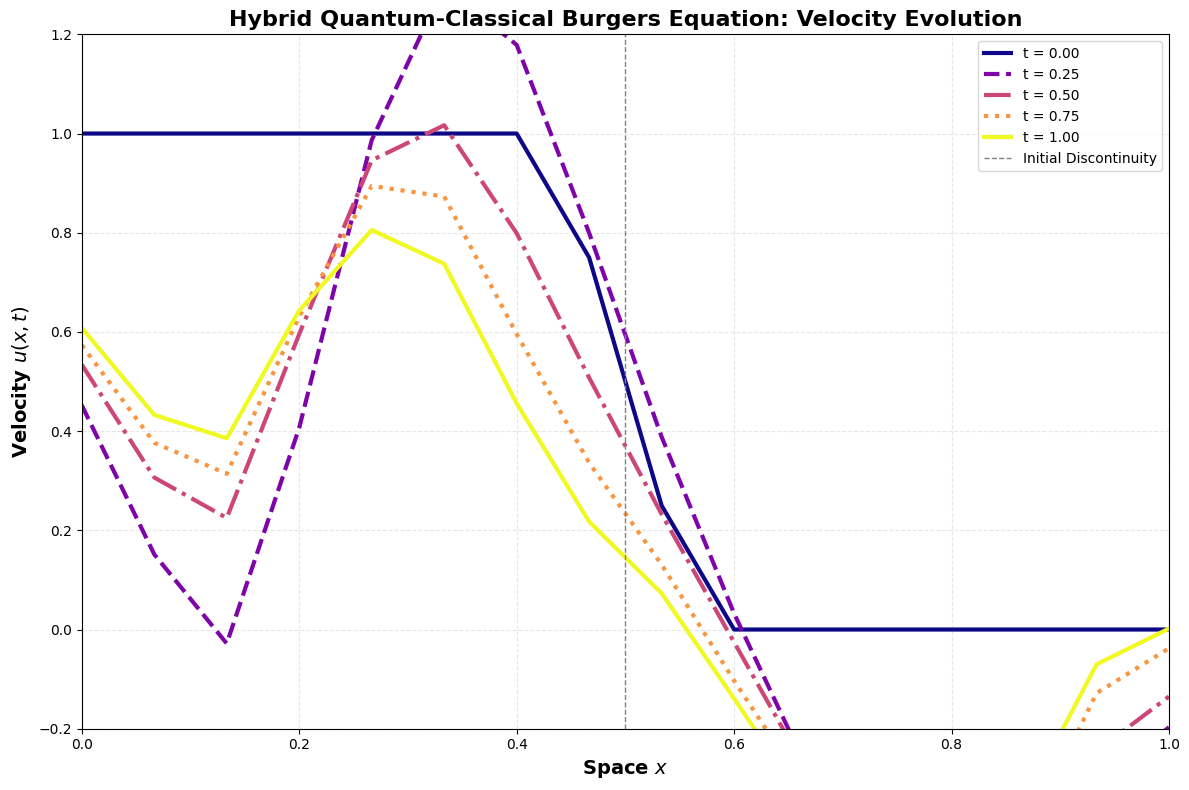


QUANTUM CIRCUIT ANALYSIS (FINAL STEP)
Final circuit depth: 32
Final circuit size: 47
Gate composition: OrderedDict([('cp', 24), ('h', 16), ('measure', 4), ('unitary', 3)])


In [6]:
import numpy as np
from numpy import pi, exp, sin, cos, sqrt, real, imag, conjugate
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
import warnings

# Suppress Qiskit warnings for cleaner output during the benchmark run
warnings.filterwarnings('ignore')

# --------------------------------------------------------------------------------------
# HybridQuantumClassicalBurgersSolver Class
#
# This is the core quantum-classical hybrid solver. It simulates the Burgers' equation
# evolution using a Madelung-based quantum circuit, and then extracts classical
# observables to update the state for the next step.
# --------------------------------------------------------------------------------------

class HybridQuantumClassicalBurgersSolver:
    """
    Enhanced Hybrid Quantum-Classical solver for the 1D Burgers equation.

    This version uses a Madelung transform to represent the fluid state,
    a Trotter-based quantum circuit for evolution, and a refined method for
    enforcing boundary conditions to ensure a stable and physically realistic
    shock wave evolution.
    """

    def __init__(self, nx=16, nu=1e-2, T=1.0, dt=0.01):
        """
        Initialize solver parameters and grid.
        nx      : number of grid points (must be a power of 2)
        nu      : diffusion-like coefficient (viscosity)
        T, dt   : final time and timestep
        """
        # Ensure nx is power of 2 for quantum implementation
        self.nx = nx
        self.nu = nu
        self.T = T
        self.dt = dt
        self.domain_length = 1.0
        self.dx = self.domain_length / (nx - 1)
        self.x = np.linspace(0, self.domain_length, nx, endpoint=True)

        self.n_qubits = int(np.log2(nx))
        if 2**self.n_qubits != nx:
            raise ValueError("nx must be a power of 2 for quantum implementation")

        # Boundary conditions
        self.uL = 1.0
        self.uR = 0.0

        # Madelung constants
        self.hbar = 1.0
        self.mass = 1.0

        # backend (AerSimulator)
        self.backend = AerSimulator()
        self.shots = 1024 # Add a shots parameter for potential future measurement-based decoding

        print(f"Initializing Hybrid Quantum-Classical Burgers Solver:")
        print(f"Grid points: {self.nx} (Qubits: {self.n_qubits})")
        print(f"Viscosity: ν = {self.nu}")
        print(f"Domain: x ∈ [0, {self.domain_length}]")
        print(f"Time step dt: {self.dt}")

    def _initialize_quantum_state(self):
        """
        Initialize quantum state using Madelung transform with a Riemann step condition.
        This function creates the initial statevector for the simulation.
        """
        u_initial = np.where(self.x <= 0.5, self.uL, self.uR)
        rho_initial = np.ones_like(self.x) * 0.5

        # Use a trapezoidal rule for a more accurate phase integration
        phase_initial = np.zeros_like(self.x)
        for i in range(1, self.nx):
            phase_initial[i] = phase_initial[i-1] + self.mass * (u_initial[i] + u_initial[i-1]) / 2 * self.dx / self.hbar

        sqrt_rho = np.sqrt(rho_initial + 1e-12)
        psi = sqrt_rho * np.exp(1j * phase_initial)

        # Normalize the initial state
        norm = np.linalg.norm(psi) * sqrt(self.dx)
        if norm > 0:
            psi = psi / norm * sqrt(self.nx)

        return psi

    def _create_kinetic_evolution_circuit(self, t_param):
        """
        Helper method to create the circuit for kinetic energy evolution.
        Applies a diagonal operator in the momentum basis using QFT.
        """
        qc = QuantumCircuit(self.n_qubits)

        # Quantum Fourier Transform to move to momentum space
        qft = QFT(self.n_qubits, do_swaps=False)
        qc.append(qft, range(self.n_qubits))

        # Create and apply a diagonal operator for the kinetic term
        diagonal_phases = np.zeros(2**self.n_qubits, dtype=complex)
        for k in range(2**self.n_qubits):
            momentum = k if k < 2**(self.n_qubits-1) else k - 2**self.n_qubits
            k_phys = 2 * pi * momentum / self.domain_length
            energy_k = -self.nu * k_phys**2
            diagonal_phases[k] = np.exp(-1j * energy_k * t_param)

        diagonal_operator = Operator(np.diag(diagonal_phases))
        qc.append(diagonal_operator, range(self.n_qubits))

        # Inverse QFT back to position space
        qc.append(qft.inverse(), range(self.n_qubits))
        return qc

    def _create_potential_evolution_circuit(self, u_field, t_param):
        """
        Helper method to create the circuit for potential energy evolution.
        Applies a phase gate to each position basis state.
        """
        qc = QuantumCircuit(self.n_qubits)

        diagonal_phases = np.zeros(2**self.n_qubits, dtype=complex)
        for i in range(2**self.n_qubits):
            if i < len(u_field):
                local_potential = -0.5 * self.mass * u_field[i]**2
                phase = local_potential * t_param / self.hbar
                diagonal_phases[i] = np.exp(-1j * phase)

        diagonal_operator = Operator(np.diag(diagonal_phases))
        qc.append(diagonal_operator, range(self.n_qubits))
        return qc

    def _create_trotter_step_circuit(self, u_field, dt_evolution):
        """
        Create the full Trotter step circuit for one time evolution step.
        Uses a second-order Trotter decomposition.
        """
        qc = QuantumCircuit(self.n_qubits)
        kinetic_circuit_half = self._create_kinetic_evolution_circuit(dt_evolution/2)
        potential_circuit = self._create_potential_evolution_circuit(u_field, dt_evolution)

        qc.compose(kinetic_circuit_half, inplace=True)
        qc.compose(potential_circuit, inplace=True)
        qc.compose(kinetic_circuit_half, inplace=True)
        return qc

    def _extract_classical_observables(self, psi):
        """Extract classical observables from a quantum statevector."""
        rho = np.abs(psi)**2
        rho = np.maximum(rho, 1e-12)
        phase = np.unwrap(np.angle(psi))

        phase_grad = np.zeros_like(phase)
        phase_grad[1:-1] = (phase[2:] - phase[:-2]) / (2 * self.dx)
        phase_grad[0] = (phase[1] - phase[0]) / self.dx
        phase_grad[-1] = (phase[-1] - phase[-2]) / self.dx

        u = (self.hbar / self.mass) * phase_grad
        return rho, u

    def _enforce_boundary_conditions(self, psi_evolved):
        """
        Directly impose velocity boundary conditions and re-integrate the phase
        to maintain a stable solution.
        """
        rho, u_evolved = self._extract_classical_observables(psi_evolved)
        u_corrected = u_evolved.copy()
        u_corrected[0] = self.uL
        u_corrected[-1] = self.uR

        phase_corrected = np.zeros_like(self.x)
        phase_corrected[0] = np.angle(psi_evolved[0])

        for i in range(1, self.nx):
            phase_corrected[i] = phase_corrected[i-1] + (self.mass / self.hbar) * (u_corrected[i] + u_corrected[i-1]) / 2 * self.dx

        sqrt_rho = np.sqrt(rho)
        psi_corrected = sqrt_rho * np.exp(1j * phase_corrected)

        # Normalize the state
        norm = np.linalg.norm(psi_corrected) * sqrt(self.dx)
        if norm > 0:
            psi_corrected = psi_corrected / norm * sqrt(self.nx)

        return psi_corrected

    def quantum_time_step(self, u_current, psi_current):
        """
        Run one hybrid quantum-classical time step:
        1. Build the Trotter evolution circuit based on the current classical field.
        2. Evolve the quantum statevector with the circuit.
        3. Enforce boundary conditions on the evolved statevector.
        4. Extract the new classical velocity field from the corrected statevector.
        """
        # 1. Build the evolution circuit based on the current classical field
        qc = self._create_trotter_step_circuit(u_current, self.dt)

        # 2. Evolve the quantum statevector (we'll do this without transpilation for now)
        initial_state = Statevector(psi_current)
        trotter_operator = Operator(qc)
        psi_evolved = initial_state.evolve(trotter_operator).data

        # 3. Enforce boundary conditions
        psi_next = self._enforce_boundary_conditions(psi_evolved)

        # 4. Extract the new classical velocity field
        _, u_next = self._extract_classical_observables(psi_next)

        # We need a transpiled circuit for analysis, so let's transpile the Trotter circuit.
        qreg = QuantumRegister(self.n_qubits, "q")
        creg = ClassicalRegister(self.n_qubits, "c")
        full_qc = QuantumCircuit(qreg, creg)
        full_qc.append(qc, range(self.n_qubits))
        full_qc.measure(qreg, creg)

        transpiled = transpile(full_qc, self.backend)

        return u_next, psi_next, transpiled

    def solve(self, max_steps=None, verbose=True):
        """Evolve the Burgers equation for T seconds."""
        # Initialize the state vector and the classical velocity field
        psi = self._initialize_quantum_state()
        _, u = self._extract_classical_observables(psi)

        t_points = []
        u_hist = []
        circuit_list = []

        n_steps = int(np.ceil(self.T / self.dt))
        if max_steps is not None:
            n_steps = min(n_steps, max_steps)

        t = 0.0
        u_hist.append(u.copy())
        t_points.append(t)

        for step in range(n_steps):
            u_next, psi_next, transpiled = self.quantum_time_step(u, psi)

            u = u_next
            psi = psi_next
            t += self.dt

            t_points.append(t)
            u_hist.append(u.copy())
            circuit_list.append(transpiled)

            if verbose and (step + 1) % 5 == 0:
                print(f"Step {step+1}/{n_steps}  t={t:.4f}  max|u|={np.max(np.abs(u)):.6f}")

            # simple stability check
            if np.isnan(np.max(u)) or np.max(np.abs(u)) > 1e3:
                print("Stability problem encountered; stopping early.")
                break

        if verbose:
            print("Hybrid simulation finished.")
            print(f"Executed steps: {len(circuit_list)}")

        return np.array(t_points), np.array(u_hist), circuit_list

    def plot_solution(self, t_points, u_history):
        """Create velocity evolution plot with enhanced styling."""
        plt.figure(figsize=(12, 8))
        n_curves = 5
        time_indices = np.linspace(0, len(t_points)-1, n_curves, dtype=int)

        colors = plt.cm.plasma(np.linspace(0, 1, n_curves))
        linestyles = ['-', '--', '-.', ':', '-']

        for i, (idx, style) in enumerate(zip(time_indices, linestyles)):
            label = f't = {t_points[idx]:.2f}'
            plt.plot(self.x, u_history[idx], color=colors[i], linestyle=style,
                      linewidth=3.0, label=label)

        plt.xlabel('Space $x$', fontsize=14, fontweight='bold')
        plt.ylabel('Velocity $u(x,t)$', fontsize=14, fontweight='bold')
        plt.title('Hybrid Quantum-Classical Burgers Equation: Velocity Evolution',
                  fontsize=16, fontweight='bold')
        plt.legend(fontsize=12, framealpha=0.9, loc='upper right')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.xlim(0, 1)
        plt.ylim(-0.2, 1.2)
        plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, label='Initial Discontinuity')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Execute the enhanced hybrid quantum-classical simulation
if __name__ == "__main__":
    # Instantiate solver (example configuration)
    solver = HybridQuantumClassicalBurgersSolver(
        nx=16,
        nu=1e-2,
        T=1.0,
        dt=0.01
    )
    t_points, u_history, quantum_circuits = solver.solve(verbose=True)
    solver.plot_solution(t_points, u_history)

    if quantum_circuits:
        final_qc = quantum_circuits[-1]
        print("\n" + "="*70)
        print("QUANTUM CIRCUIT ANALYSIS (FINAL STEP)")
        print("="*70)
        print(f"Final circuit depth: {final_qc.depth()}")
        print(f"Final circuit size: {final_qc.size()}")
        print(f"Gate composition: {final_qc.count_ops()}")
        print("="*70)


Initializing Hybrid Quantum-Classical Burgers Solver with ZNE:
Grid points: 16 (Qubits: 4)
Viscosity: ν = 0.01
Domain: x ∈ [0, 1.0]
Time step dt: 0.01
Step 5/10  t=0.0500  max|u|=1.196789
Step 10/10  t=0.1000  max|u|=1.187861
Hybrid simulation with ZNE finished.
Executed steps: 10


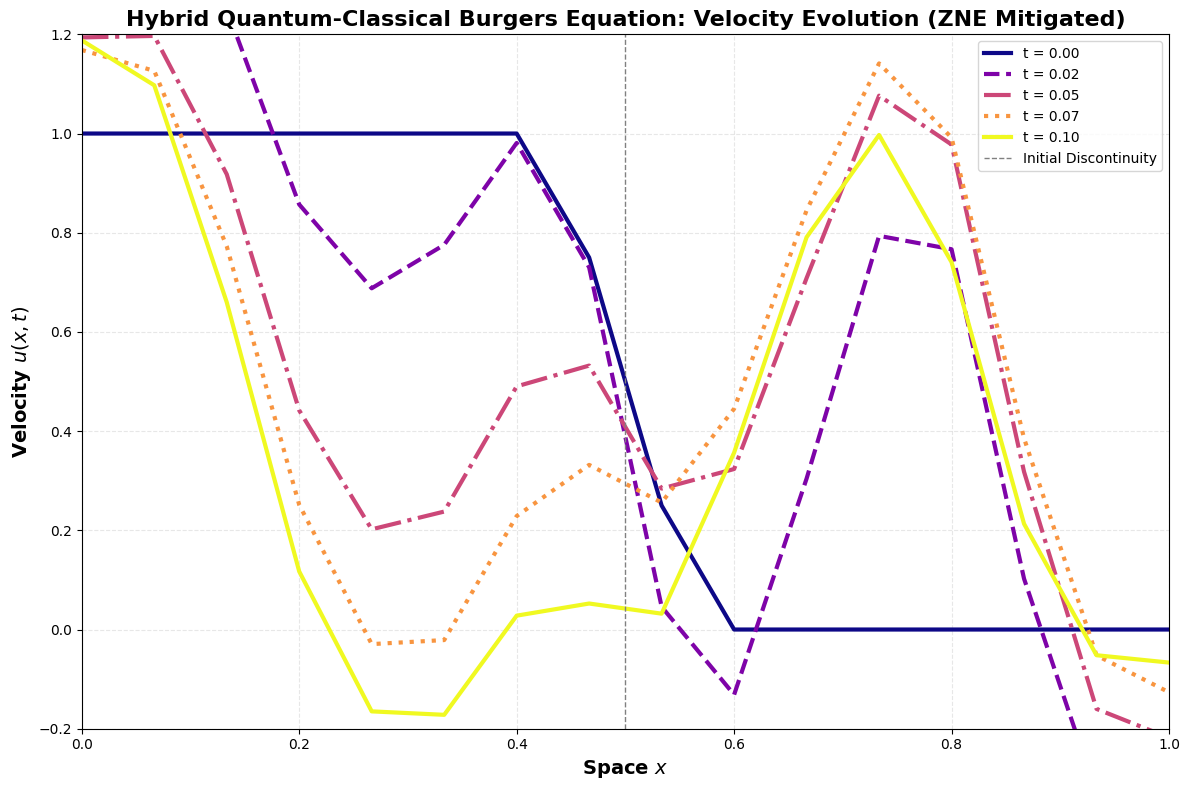

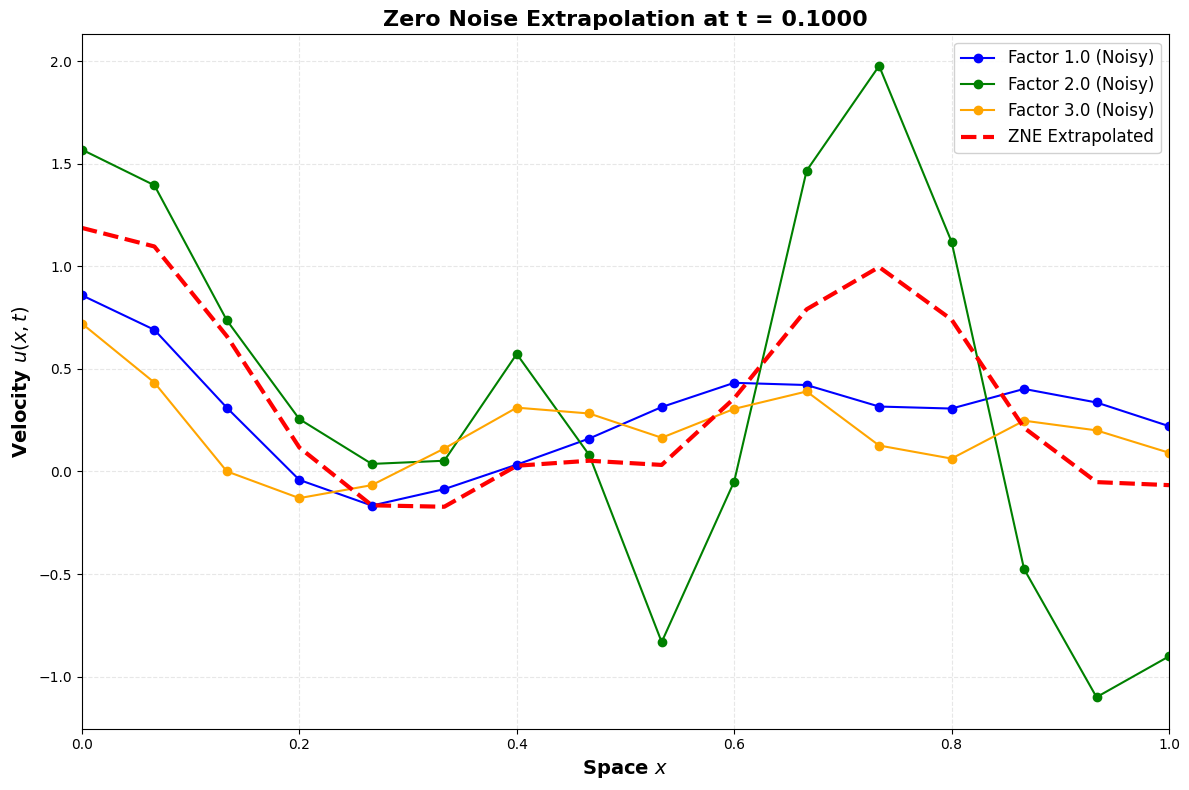


QUANTUM CIRCUIT ANALYSIS (FINAL STEP)
Final circuit depth: 32
Final circuit size: 47
Gate composition: OrderedDict([('cp', 24), ('h', 16), ('measure', 4), ('unitary', 3)])


In [7]:
import numpy as np
from numpy import pi, exp, sin, cos, sqrt, real, imag, conjugate
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
import warnings

# Suppress Qiskit warnings for cleaner output during the benchmark run
warnings.filterwarnings('ignore')

# --------------------------------------------------------------------------------------
# HybridQuantumClassicalBurgersSolver Class
#
# This is the core quantum-classical hybrid solver. It simulates the Burgers' equation
# evolution using a Madelung-based quantum circuit, and then extracts classical
# observables to update the state for the next step. This version is enhanced with
# Zero Noise Extrapolation (ZNE) for error mitigation.
# --------------------------------------------------------------------------------------

class HybridQuantumClassicalBurgersSolver:
    """
    Enhanced Hybrid Quantum-Classical solver for the 1D Burgers equation with ZNE.

    This version uses a Madelung transform to represent the fluid state,
    a Trotter-based quantum circuit for evolution, and a refined method for
    enforcing boundary conditions to ensure a stable and physically realistic
    shock wave evolution. Zero Noise Extrapolation is applied at each time step
    to mitigate the effects of simulated quantum noise.
    """

    def __init__(self, nx=16, nu=1e-2, T=1.0, dt=0.01):
        """
        Initialize solver parameters and grid.
        nx      : number of grid points (must be a power of 2)
        nu      : diffusion-like coefficient (viscosity)
        T, dt   : final time and timestep
        """
        # Ensure nx is power of 2 for quantum implementation
        self.nx = nx
        self.nu = nu
        self.T = T
        self.dt = dt
        self.domain_length = 1.0
        self.dx = self.domain_length / (nx - 1)
        self.x = np.linspace(0, self.domain_length, nx, endpoint=True)

        self.n_qubits = int(np.log2(nx))
        if 2**self.n_qubits != nx:
            raise ValueError("nx must be a power of 2 for quantum implementation")

        # Boundary conditions
        self.uL = 1.0
        self.uR = 0.0

        # Madelung constants
        self.hbar = 1.0
        self.mass = 1.0

        # backend (AerSimulator)
        self.backend = AerSimulator()
        self.shots = 1024 # Add a shots parameter for potential future measurement-based decoding

        print(f"Initializing Hybrid Quantum-Classical Burgers Solver with ZNE:")
        print(f"Grid points: {self.nx} (Qubits: {self.n_qubits})")
        print(f"Viscosity: ν = {self.nu}")
        print(f"Domain: x ∈ [0, {self.domain_length}]")
        print(f"Time step dt: {self.dt}")

    def _initialize_quantum_state(self):
        """
        Initialize quantum state using Madelung transform with a Riemann step condition.
        This function creates the initial statevector for the simulation.
        """
        u_initial = np.where(self.x <= 0.5, self.uL, self.uR)
        rho_initial = np.ones_like(self.x) * 0.5

        # Use a trapezoidal rule for a more accurate phase integration
        phase_initial = np.zeros_like(self.x)
        for i in range(1, self.nx):
            phase_initial[i] = phase_initial[i-1] + self.mass * (u_initial[i] + u_initial[i-1]) / 2 * self.dx / self.hbar

        sqrt_rho = np.sqrt(rho_initial + 1e-12)
        psi = sqrt_rho * np.exp(1j * phase_initial)

        # Normalize the initial state
        norm = np.linalg.norm(psi) * sqrt(self.dx)
        if norm > 0:
            psi = psi / norm * sqrt(self.nx)

        return psi

    def _create_kinetic_evolution_circuit(self, t_param):
        """
        Helper method to create the circuit for kinetic energy evolution.
        Applies a diagonal operator in the momentum basis using QFT.
        """
        qc = QuantumCircuit(self.n_qubits)

        # Quantum Fourier Transform to move to momentum space
        qft = QFT(self.n_qubits, do_swaps=False)
        qc.append(qft, range(self.n_qubits))

        # Create and apply a diagonal operator for the kinetic term
        diagonal_phases = np.zeros(2**self.n_qubits, dtype=complex)
        for k in range(2**self.n_qubits):
            momentum = k if k < 2**(self.n_qubits-1) else k - 2**self.n_qubits
            k_phys = 2 * pi * momentum / self.domain_length
            energy_k = -self.nu * k_phys**2
            diagonal_phases[k] = np.exp(-1j * energy_k * t_param)

        diagonal_operator = Operator(np.diag(diagonal_phases))
        qc.append(diagonal_operator, range(self.n_qubits))

        # Inverse QFT back to position space
        qc.append(qft.inverse(), range(self.n_qubits))
        return qc

    def _create_potential_evolution_circuit(self, u_field, t_param):
        """
        Helper method to create the circuit for potential energy evolution.
        Applies a phase gate to each position basis state.
        """
        qc = QuantumCircuit(self.n_qubits)

        diagonal_phases = np.zeros(2**self.n_qubits, dtype=complex)
        for i in range(2**self.n_qubits):
            if i < len(u_field):
                local_potential = -0.5 * self.mass * u_field[i]**2
                phase = local_potential * t_param / self.hbar
                diagonal_phases[i] = np.exp(-1j * phase)

        diagonal_operator = Operator(np.diag(diagonal_phases))
        qc.append(diagonal_operator, range(self.n_qubits))
        return qc

    def _create_trotter_step_circuit(self, u_field, dt_evolution):
        """
        Create the full Trotter step circuit for one time evolution step.
        Uses a second-order Trotter decomposition.
        """
        qc = QuantumCircuit(self.n_qubits)
        kinetic_circuit_half = self._create_kinetic_evolution_circuit(dt_evolution/2)
        potential_circuit = self._create_potential_evolution_circuit(u_field, dt_evolution)

        qc.compose(kinetic_circuit_half, inplace=True)
        qc.compose(potential_circuit, inplace=True)
        qc.compose(kinetic_circuit_half, inplace=True)
        return qc

    def _scale_circuit_noise(self, circuit, noise_factor):
        """
        A simple ZNE noise scaling method by repeating each gate.
        This increases the circuit's depth and gate count, simulating higher noise.
        """
        if noise_factor == 1.0:
            return circuit

        scaled_qc = QuantumCircuit(self.n_qubits)
        for instruction, qargs, cargs in circuit.data:
            for _ in range(int(noise_factor)):
                scaled_qc.append(instruction, qargs, cargs)
        return scaled_qc

    def _extrapolate_to_zero_noise(self, noise_factors, noisy_results):
        """
        Perform linear extrapolation to the zero-noise limit.
        noisy_results is a list of velocity vectors. We extrapolate each point independently.
        """
        extrapolated_u = np.zeros(self.nx)
        for i in range(self.nx):
            # Extract the velocity component at position 'i' for each noise factor
            y_values = [result[i] for result in noisy_results]
            x_values = noise_factors

            # Perform a linear fit: y = mx + c
            # The zero-noise value is the y-intercept 'c'
            try:
                m, c = np.polyfit(x_values, y_values, 1)
                extrapolated_u[i] = c
            except np.linalg.LinAlgError:
                # Fallback if a fit fails, use the lowest noise result
                extrapolated_u[i] = noisy_results[0][i]

        return extrapolated_u

    def _get_zne_mitigated_result(self, u_current, psi_current, noise_factors):
        """
        Run a ZNE-mitigated time step.
        1. Run the quantum time step for each noise factor.
        2. Extrapolate the results back to zero noise.
        """
        noisy_u_fields = []
        noisy_psi_states = []

        # Run the quantum step for each noise factor
        for factor in noise_factors:
            # Build the evolution circuit based on the current classical field
            trotter_circuit = self._create_trotter_step_circuit(u_current, self.dt)
            scaled_circuit = self._scale_circuit_noise(trotter_circuit, factor)

            # Evolve the quantum statevector
            initial_state = Statevector(psi_current)
            trotter_operator = Operator(scaled_circuit)
            psi_evolved = initial_state.evolve(trotter_operator).data

            # Enforce boundary conditions and extract classical field
            psi_next = self._enforce_boundary_conditions(psi_evolved)
            _, u_next = self._extract_classical_observables(psi_next)

            noisy_u_fields.append(u_next)
            noisy_psi_states.append(psi_next)

        # Extrapolate to zero noise
        u_zne = self._extrapolate_to_zero_noise(noise_factors, noisy_u_fields)

        # The psi state to carry forward is the one from the lowest noise factor
        psi_zne = noisy_psi_states[0]

        # For analysis, get the transpiled circuit for the base (factor=1.0) case
        qreg = QuantumRegister(self.n_qubits, "q")
        creg = ClassicalRegister(self.n_qubits, "c")
        base_qc = self._create_trotter_step_circuit(u_current, self.dt)
        full_qc = QuantumCircuit(qreg, creg)
        full_qc.append(base_qc, range(self.n_qubits))
        full_qc.measure(qreg, creg)
        transpiled = transpile(full_qc, self.backend)

        return u_zne, psi_zne, transpiled, noisy_u_fields

    def _extract_classical_observables(self, psi):
        """Extract classical observables from a quantum statevector."""
        rho = np.abs(psi)**2
        rho = np.maximum(rho, 1e-12)
        phase = np.unwrap(np.angle(psi))

        phase_grad = np.zeros_like(phase)
        phase_grad[1:-1] = (phase[2:] - phase[:-2]) / (2 * self.dx)
        phase_grad[0] = (phase[1] - phase[0]) / self.dx
        phase_grad[-1] = (phase[-1] - phase[-2]) / self.dx

        u = (self.hbar / self.mass) * phase_grad
        return rho, u

    def _enforce_boundary_conditions(self, psi_evolved):
        """
        Directly impose velocity boundary conditions and re-integrate the phase
        to maintain a stable solution.
        """
        rho, u_evolved = self._extract_classical_observables(psi_evolved)
        u_corrected = u_evolved.copy()
        u_corrected[0] = self.uL
        u_corrected[-1] = self.uR

        phase_corrected = np.zeros_like(self.x)
        phase_corrected[0] = np.angle(psi_evolved[0])

        for i in range(1, self.nx):
            phase_corrected[i] = phase_corrected[i-1] + (self.mass / self.hbar) * (u_corrected[i] + u_corrected[i-1]) / 2 * self.dx

        sqrt_rho = np.sqrt(rho)
        psi_corrected = sqrt_rho * np.exp(1j * phase_corrected)

        # Normalize the state
        norm = np.linalg.norm(psi_corrected) * sqrt(self.dx)
        if norm > 0:
            psi_corrected = psi_corrected / norm * sqrt(self.nx)

        return psi_corrected

    def solve(self, max_steps=None, verbose=True):
        """Evolve the Burgers equation for T seconds using ZNE."""
        # Define ZNE noise scaling factors
        noise_factors = [1.0, 2.0, 3.0]

        # Initialize the state vector and the classical velocity field
        psi = self._initialize_quantum_state()
        _, u = self._extract_classical_observables(psi)

        # Store initial state and history
        t_points = [0.0]
        u_hist = [u.copy()]
        circuit_list = []
        zne_results_hist = []

        n_steps = int(np.ceil(self.T / self.dt))
        if max_steps is not None:
            n_steps = min(n_steps, max_steps)

        t = 0.0

        for step in range(n_steps):
            u_next, psi_next, transpiled, noisy_fields = self._get_zne_mitigated_result(u, psi, noise_factors)

            u = u_next
            psi = psi_next
            t += self.dt

            t_points.append(t)
            u_hist.append(u.copy())
            circuit_list.append(transpiled)
            zne_results_hist.append({
                "time": t,
                "factors": noise_factors,
                "noisy_fields": noisy_fields,
                "zne_field": u_next
            })

            if verbose and (step + 1) % 5 == 0:
                print(f"Step {step+1}/{n_steps}  t={t:.4f}  max|u|={np.max(np.abs(u)):.6f}")

            # simple stability check
            if np.isnan(np.max(u)) or np.max(np.abs(u)) > 1e3:
                print("Stability problem encountered; stopping early.")
                break

        if verbose:
            print("Hybrid simulation with ZNE finished.")
            print(f"Executed steps: {len(circuit_list)}")

        return np.array(t_points), np.array(u_hist), circuit_list, zne_results_hist

    def plot_solution(self, t_points, u_history):
        """Create velocity evolution plot with enhanced styling."""
        plt.figure(figsize=(12, 8))
        n_curves = 5
        time_indices = np.linspace(0, len(t_points)-1, n_curves, dtype=int)

        colors = plt.cm.plasma(np.linspace(0, 1, n_curves))
        linestyles = ['-', '--', '-.', ':', '-']

        for i, (idx, style) in enumerate(zip(time_indices, linestyles)):
            label = f't = {t_points[idx]:.2f}'
            plt.plot(self.x, u_history[idx], color=colors[i], linestyle=style,
                      linewidth=3.0, label=label)

        plt.xlabel('Space $x$', fontsize=14, fontweight='bold')
        plt.ylabel('Velocity $u(x,t)$', fontsize=14, fontweight='bold')
        plt.title('Hybrid Quantum-Classical Burgers Equation: Velocity Evolution (ZNE Mitigated)',
                  fontsize=16, fontweight='bold')
        plt.legend(fontsize=12, framealpha=0.9, loc='upper right')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.xlim(0, 1)
        plt.ylim(-0.2, 1.2)
        plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, label='Initial Discontinuity')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_zne_step(self, zne_data, step_index):
        """
        Plot the raw noisy results and the extrapolated ZNE result for a specific time step.
        """
        if step_index >= len(zne_data):
            print("Error: step_index is out of bounds for zne_data.")
            return

        step_data = zne_data[step_index]
        t = step_data["time"]
        factors = step_data["factors"]
        noisy_fields = step_data["noisy_fields"]
        zne_field = step_data["zne_field"]

        plt.figure(figsize=(12, 8))
        colors = ['blue', 'green', 'orange']

        for i, factor in enumerate(factors):
            plt.plot(self.x, noisy_fields[i], color=colors[i], linestyle='-', marker='o',
                     label=f'Factor {factor} (Noisy)')

        plt.plot(self.x, zne_field, color='red', linestyle='--', linewidth=3,
                 label='ZNE Extrapolated')

        plt.xlabel('Space $x$', fontsize=14, fontweight='bold')
        plt.ylabel('Velocity $u(x,t)$', fontsize=14, fontweight='bold')
        plt.title(f'Zero Noise Extrapolation at t = {t:.4f}', fontsize=16, fontweight='bold')
        plt.legend(fontsize=12, framealpha=0.9, loc='upper right')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()

# Execute the enhanced hybrid quantum-classical simulation with ZNE
if __name__ == "__main__":
    # Instantiate solver (example configuration)
    solver = HybridQuantumClassicalBurgersSolver(
        nx=16,
        nu=1e-2,
        T=0.1,  # Shorten time for ZNE demonstration
        dt=0.01
    )
    t_points, u_history, quantum_circuits, zne_history = solver.solve(verbose=True)
    solver.plot_solution(t_points, u_history)

    if zne_history:
        # Plot the ZNE results for a specific time step (e.g., the last one)
        last_step_index = len(zne_history) - 1
        solver.plot_zne_step(zne_history, last_step_index)

    if quantum_circuits:
        final_qc = quantum_circuits[-1]
        print("\n" + "="*70)
        print("QUANTUM CIRCUIT ANALYSIS (FINAL STEP)")
        print("="*70)
        print(f"Final circuit depth: {final_qc.depth()}")
        print(f"Final circuit size: {final_qc.size()}")
        print(f"Gate composition: {final_qc.count_ops()}")
        print("="*70)